In [1]:
# CELDAS 1 & 2: Importar Librerías y Definir Rutas
import pandas as pd
import numpy as np
import re
import os

# Ajusta la ruta si es necesario. '..' sube un nivel de directorio.
RAW_FILE = '../data/raw/mlb_standings_historicos_scraped_selenium.csv'
PROCESSED_FILE = '../data/processed/mlb_standings_clean.csv'

# 1. Cargar el DataFrame
df = pd.read_csv(RAW_FILE)

# Revisión inicial
print(f"Filas cargadas desde RAW: {len(df)}")
df.info()
df.head()

Filas cargadas desde RAW: 690
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temporada           690 non-null    int64  
 1   Liga_Division       690 non-null    object 
 2   Equipo              690 non-null    object 
 3   Victorias           690 non-null    int64  
 4   Derrotas            690 non-null    int64  
 5   Porcentaje_Ganador  690 non-null    float64
 6   Record_Casa         690 non-null    object 
 7   Record_Visitante    690 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 43.3+ KB


,Temporada,Liga_Division,Equipo,Victorias,Derrotas,Porcentaje_Ganador,Record_Casa,Record_Visitante
0,2003,Overall,New York Yankees,101,61,0.623,50-32,51-29
1,2003,Overall,Atlanta Braves,101,61,0.623,55-26,46-35
2,2003,Overall,San Francisco Giants,100,61,0.621,57-24,43-37
3,2003,Overall,Oakland Athletics,96,66,0.593,57-24,39-42
4,2003,Overall,Boston Red Sox,95,67,0.586,53-28,42-39


In [2]:
# CELDA 3: Definir y Aplicar Limpieza de Caracteres

FRANCHISE_MAP = {
    'Florida Marlins': 'Miami Marlins',
    'Montreal Expos': 'Washington Nationals',
    'Anaheim Angels': 'Los Angeles Angels',
    'Tampa Bay Devil Rays': 'Tampa Bay Rays',
    # AMPLÍA ESTE DICCIONARIO
}

def clean_special_characters(text):
    if pd.isna(text):
        return text
    
    # 1. Eliminar marcadores de playoff y guiones residuales
    text = str(text).replace('x - ', '').replace('y - ', '').replace('y -', '').replace('* - ', '').replace(' - -', '').strip()
    
    # 2. Mantener solo alfanuméricos y espacios
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Aplicar limpieza y mapeo
df['Equipo'] = df['Equipo'].apply(clean_special_characters)
df['Liga_Division'] = df['Liga_Division'].apply(clean_special_characters)
df['Equipo'] = df['Equipo'].replace(FRANCHISE_MAP)

# Verificar nombres únicos para encontrar más inconsistencias
print("Verificación de los primeros 10 nombres de equipo después de la limpieza:")
print(df['Equipo'].unique()[:10])

Verificación de los primeros 10 nombres de equipo después de la limpieza:
['New York Yankees' 'Atlanta Braves' 'San Francisco Giants'
 'Oakland Athletics' 'Boston Red Sox' 'Seattle Mariners' 'Miami Marlins'
 'Minnesota Twins' 'Chicago Cubs' 'Houston Astros']


In [3]:
# CELDA 4: Desglose W-L y Conversión a int64

# Desglose de strings (Crea V_Casa, D_Casa, etc. como strings/objects)
df[['V_Casa', 'D_Casa']] = df['Record_Casa'].str.split('-', expand=True)
df[['V_Visitante', 'D_Visitante']] = df['Record_Visitante'].str.split('-', expand=True)

# Eliminar las columnas originales de string
df.drop(columns=['Record_Casa', 'Record_Visitante'], inplace=True)

# ----------------------------------------------------------------
# CONVERSIÓN A int64 SEGURA
# ----------------------------------------------------------------
cols_to_convert_to_int = ['V_Casa', 'D_Casa', 'V_Visitante', 'D_Visitante']

for col in cols_to_convert_to_int:
    # 1. Coerción a numérico: Convierte strings a float, y los strings malos a NaN (float)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 2. Rellena NaNs con 0 (Necesario para la conversión a int64)
    if df[col].isnull().any():
        print(f"⚠️ ¡Advertencia! Se encontraron {df[col].isnull().sum()} NaNs en {col}. Rellenando con 0.")
        df[col].fillna(0, inplace=True) 
        
    # 3. Conversión final a int64
    df[col] = df[col].astype('int64')

# VERIFICACIÓN: Muestra los tipos de datos de las columnas de récords
print("\nTipos de datos después de la conversión:")
print(df[cols_to_convert_to_int].dtypes)


Tipos de datos después de la conversión:
V_Casa         int64
D_Casa         int64
V_Visitante    int64
D_Visitante    int64
dtype: object


In [4]:
# CELDA 5: Feature Engineering y Carga (L)

print("\nGenerando nuevas características...")

# PCT en Casa (Resultado es float64, lo cual es correcto para porcentajes)
df['PCT_Casa'] = df['V_Casa'] / (df['V_Casa'] + df['D_Casa'])

# PCT de Visitante
df['PCT_Visitante'] = df['V_Visitante'] / (df['V_Visitante'] + df['D_Visitante'])

# Balance Casa vs. Visitante
df['Balance_Casa_Visitante'] = df['PCT_Casa'] - df['PCT_Visitante']

# Manejo de NaNs resultantes de divisiones por cero (0/0)
df[['PCT_Casa', 'PCT_Visitante', 'Balance_Casa_Visitante']] = df[['PCT_Casa', 'PCT_Visitante', 'Balance_Casa_Visitante']].fillna(0)

# ----------------------------------------------------------------
# FASE DE CARGA (L)
# ----------------------------------------------------------------
os.makedirs(os.path.dirname(PROCESSED_FILE), exist_ok=True)
df.to_csv(PROCESSED_FILE, index=False, encoding='utf-8')

print(f"\n✅ Transformación completada. Datos guardados en: {PROCESSED_FILE}")
df.info()


Generando nuevas características...

✅ Transformación completada. Datos guardados en: ../data/processed/mlb_standings_clean.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temporada               690 non-null    int64  
 1   Liga_Division           690 non-null    object 
 2   Equipo                  690 non-null    object 
 3   Victorias               690 non-null    int64  
 4   Derrotas                690 non-null    int64  
 5   Porcentaje_Ganador      690 non-null    float64
 6   V_Casa                  690 non-null    int64  
 7   D_Casa                  690 non-null    int64  
 8   V_Visitante             690 non-null    int64  
 9   D_Visitante             690 non-null    int64  
 10  PCT_Casa                690 non-null    float64
 11  PCT_Visitante           690 non-null    float64
 12  Balance_Casa_Visita

In [6]:
df.head()

,Temporada,Liga_Division,Equipo,Victorias,Derrotas,Porcentaje_Ganador,V_Casa,D_Casa,V_Visitante,D_Visitante,PCT_Casa,PCT_Visitante,Balance_Casa_Visitante
0,2003,Overall,New York Yankees,101,61,0.623,50,32,51,29,0.609756,0.637500,-0.027744
1,2003,Overall,Atlanta Braves,101,61,0.623,55,26,46,35,0.679012,0.567901,0.111111
2,2003,Overall,San Francisco Giants,100,61,0.621,57,24,43,37,0.703704,0.537500,0.166204
3,2003,Overall,Oakland Athletics,96,66,0.593,57,24,39,42,0.703704,0.481481,0.222222
4,2003,Overall,Boston Red Sox,95,67,0.586,53,28,42,39,0.654321,0.518519,0.135802


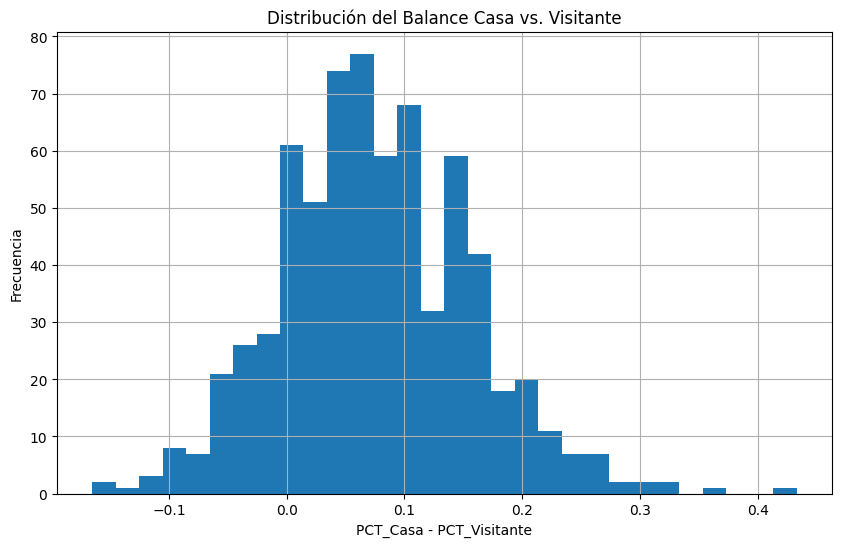

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['Balance_Casa_Visitante'].hist(bins=30)
plt.title('Distribución del Balance Casa vs. Visitante')
plt.xlabel('PCT_Casa - PCT_Visitante')
plt.ylabel('Frecuencia')
plt.show()
# Una distribución centrada en cero (o ligeramente positiva) es lo esperado.

In [11]:
# ¿Las victorias totales están más correlacionadas con el rendimiento en casa o fuera?
print("Correlación de Victorias Totales:")
print(df[['Victorias', 'PCT_Casa', 'PCT_Visitante']].corr().loc['Victorias'])

Correlación de Victorias Totales:
Victorias        1.000000
PCT_Casa         0.617100
PCT_Visitante    0.682199
Name: Victorias, dtype: float64
